# India Aviation — Domestic City Preprocessing

This notebook performs the following steps on `domestic/city.csv`:
1. **Load & Explore**
2. **Missing Value Imputation** (Mean/Median/Mode, and optional KNN)
3. **Outlier Detection** (Z-score) and optional capping
4. **Data Cleaning & Standardization**
5. **Feature Extraction** (Totals, Growth)
6. **Correlation Analysis** and **Heatmap (matplotlib)**

> Note: This dataset represents **domestic city-pairs** traffic.

In [1]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)

## 1) Load & Explore

In [2]:
# Path to the CSV (change if needed)
FILE_PATH = 'city.csv'  # put your path if different

# Read
df = pd.read_csv(FILE_PATH)

# Basic exploration
print('Shape:', df.shape)
print('Columns:', list(df.columns))
print('\nHead:')
display(df.head())
print('\nMissing values:')
display(df.isnull().sum())
print('\nDtypes:')
display(df.dtypes)

Shape: (56047, 10)
Columns: ['Year', 'Month', 'City1', 'City2', 'PaxToCity2', 'PaxFromCity2', 'FreightToCity2', 'FreightFromCity2', 'MailToCity2', 'MailFromCity2']

Head:


,Year,Month,City1,City2,PaxToCity2,PaxFromCity2,FreightToCity2,FreightFromCity2,MailToCity2,MailFromCity2
0,2021,12,ADAMPUR,AHMEDABAD,30.0,0.0,0.0,0.00,0.0,0.0
1,2018,5,ADAMPUR,DELHI,2258.0,2190.0,0.0,0.86,0.0,0.0
2,2018,6,ADAMPUR,DELHI,1984.0,1981.0,0.0,4.33,0.0,0.0
3,2018,7,ADAMPUR,DELHI,2333.0,2205.0,0.0,1.93,0.0,0.0
4,2018,8,ADAMPUR,DELHI,2146.0,1981.0,0.0,0.48,0.0,0.0



Missing values:


Year                    0
Month                   0
City1                   0
City2                   0
PaxToCity2              0
PaxFromCity2            0
FreightToCity2      11695
FreightFromCity2    11694
MailToCity2         11700
MailFromCity2       11697
dtype: int64


Dtypes:


Year                  int64
Month                 int64
City1                object
City2                object
PaxToCity2          float64
PaxFromCity2        float64
FreightToCity2      float64
FreightFromCity2    float64
MailToCity2         float64
MailFromCity2       float64
dtype: object

## 2) Missing Value Imputation
- Fill numeric columns with **median** as a baseline.
- (Optional) Run **KNN Imputer** for multivariate imputation.

You can toggle KNN via the `USE_KNN_IMPUTER` flag.

In [ ]:
# Copy for safety
df_proc = df.copy()

# Normalize column names early
df_proc.columns = df_proc.columns.str.strip().str.lower()

# Identify numeric columns
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)

# Median imputation
df_proc[numeric_cols] = df_proc[numeric_cols].fillna(df_proc[numeric_cols].median())

# Optional: KNN Imputer
USE_KNN_IMPUTER = True
if USE_KNN_IMPUTER and len(numeric_cols) > 0:
    knn = KNNImputer(n_neighbors=3)
    df_proc[numeric_cols] = knn.fit_transform(df_proc[numeric_cols])

print('Missing after imputation:')
display(df_proc.isnull().sum())


Numeric columns: ['year', 'month', 'paxtocity2', 'paxfromcity2', 'freighttocity2', 'freightfromcity2', 'mailtocity2', 'mailfromcity2']
Missing after imputation:


year                0
month               0
city1               0
city2               0
paxtocity2          0
paxfromcity2        0
freighttocity2      0
freightfromcity2    0
mailtocity2         0
mailfromcity2       0
dtype: int64

## 3) Outlier Detection (Z-score)
We flag outliers where `|z| > 3` per numeric column. Optionally cap values to
`mean ± 3*std` to reduce extreme influence without dropping rows.

In [5]:
# Z-Score computation
# z = (df_proc[numeric_cols] - df_proc[numeric_cols].mean()) / df_proc[numeric_cols].std(ddof=0)
# outlier_mask = (z.abs() > 3)
# outlier_counts = outlier_mask.sum().sort_values(ascending=False)
# print('Outliers (|z|>3) per column:')
# display(outlier_counts)

# Optional capping (winsorization-like)
CAP_OUTLIERS = False  # set True to cap
if CAP_OUTLIERS:
    means = df_proc[numeric_cols].mean()
    stds = df_proc[numeric_cols].std(ddof=0)
    upper = means + 3*stds
    lower = means - 3*stds
    df_proc[numeric_cols] = np.minimum(df_proc[numeric_cols], upper)
    df_proc[numeric_cols] = np.maximum(df_proc[numeric_cols], lower)

## 4) Data Cleaning & Standardization
- Ensure **Year/Month** are integers
- Create a proper **`date`** column (YYYY-MM-01)
- Upper-case cities
- Standardize numeric features with **z-score** (creates `*_scaled` columns)

In [6]:
# Ensure expected columns
expected = {'year','month','city1','city2','paxtocity2','paxfromcity2',
            'freighttocity2','freightfromcity2','mailtocity2','mailfromcity2'}
missing_expected = expected - set(df_proc.columns)
print('Missing expected columns (if any):', missing_expected)

# Clean types
if 'year' in df_proc.columns:
    df_proc['year'] = pd.to_numeric(df_proc['year'], errors='coerce').astype('Int64')
if 'month' in df_proc.columns:
    df_proc['month'] = pd.to_numeric(df_proc['month'], errors='coerce').astype('Int64')

# Date column
if {'year','month'} <= set(df_proc.columns):
    df_proc['date'] = pd.to_datetime(
        df_proc['year'].astype('Int64').astype(str) + '-' + df_proc['month'].astype('Int64').astype(str) + '-01',
        errors='coerce'
    )

# City name cleanup
for col in ['city1','city2']:
    if col in df_proc.columns:
        df_proc[col] = df_proc[col].astype(str).str.strip().str.upper()

# Standardize numeric columns into new *_scaled columns
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df_proc[numeric_cols]) if numeric_cols else None
if numeric_cols:
    for i, col in enumerate(numeric_cols):
        df_proc[col + '_scaled'] = scaled_vals[:, i]

display(df_proc.head())

Missing expected columns (if any): set()


,year,month,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,date,year_scaled,month_scaled,paxtocity2_scaled,paxfromcity2_scaled,freighttocity2_scaled,freightfromcity2_scaled,mailtocity2_scaled,mailfromcity2_scaled
0,2021,12,ADAMPUR,AHMEDABAD,30.0,0.0,0.0,0.00,0.0,0.0,2021-12-01,0.231384,1.543742,-0.457048,-0.457371,-0.211484,-0.196652,-0.285652,-0.249218
1,2018,5,ADAMPUR,DELHI,2258.0,2190.0,0.0,0.86,0.0,0.0,2018-05-01,-0.834132,-0.434255,-0.359395,-0.361311,-0.211484,-0.192234,-0.285652,-0.249218
2,2018,6,ADAMPUR,DELHI,1984.0,1981.0,0.0,4.33,0.0,0.0,2018-06-01,-0.834132,-0.151684,-0.371405,-0.370479,-0.211484,-0.174409,-0.285652,-0.249218
3,2018,7,ADAMPUR,DELHI,2333.0,2205.0,0.0,1.93,0.0,0.0,2018-07-01,-0.834132,0.130887,-0.356108,-0.360653,-0.211484,-0.186738,-0.285652,-0.249218
4,2018,8,ADAMPUR,DELHI,2146.0,1981.0,0.0,0.48,0.0,0.0,2018-08-01,-0.834132,0.413458,-0.364304,-0.370479,-0.211484,-0.194186,-0.285652,-0.249218


## 5) Feature Extraction
- `total_passengers = PaxToCity2 + PaxFromCity2`
- `total_freight = FreightToCity2 + FreightFromCity2`
- `total_mail = MailToCity2 + MailFromCity2`
- **Growth %** month-over-month per route (City1, City2)
- Add `traffic_type = 'domestic'`

In [8]:
# Totals
def safe_sum(a, b):
    return (a.fillna(0) if a is not None else 0) + (b.fillna(0) if b is not None else 0)

if {'paxtocity2','paxfromcity2'} <= set(df_proc.columns):
    df_proc['total_passengers'] = df_proc['paxtocity2'] + df_proc['paxfromcity2']
if {'freighttocity2','freightfromcity2'} <= set(df_proc.columns):
    df_proc['total_freight'] = df_proc['freighttocity2'] + df_proc['freightfromcity2']
if {'mailtocity2','mailfromcity2'} <= set(df_proc.columns):
    df_proc['total_mail'] = df_proc['mailtocity2'] + df_proc['mailfromcity2']

# Growth % per (City1, City2) ordered by date
if {'city1','city2','date','total_passengers'} <= set(df_proc.columns):
    df_proc = df_proc.sort_values(['city1','city2','date'])
    df_proc['pax_growth_pct'] = (
        df_proc.groupby(['city1','city2'])['total_passengers']
        .pct_change()
        * 100
    )

df_proc['traffic_type'] = 'domestic'
display(df_proc.head())

,year,month,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,date,year_scaled,month_scaled,paxtocity2_scaled,paxfromcity2_scaled,freighttocity2_scaled,freightfromcity2_scaled,mailtocity2_scaled,mailfromcity2_scaled,total_passengers,total_freight,total_mail,pax_growth_pct,traffic_type
0,2021,12,ADAMPUR,AHMEDABAD,30.0,0.0,0.0,0.00,0.0,0.0,2021-12-01,0.231384,1.543742,-0.457048,-0.457371,-0.211484,-0.196652,-0.285652,-0.249218,30.0,0.00,0.0,NaN,domestic
1,2018,5,ADAMPUR,DELHI,2258.0,2190.0,0.0,0.86,0.0,0.0,2018-05-01,-0.834132,-0.434255,-0.359395,-0.361311,-0.211484,-0.192234,-0.285652,-0.249218,4448.0,0.86,0.0,NaN,domestic
2,2018,6,ADAMPUR,DELHI,1984.0,1981.0,0.0,4.33,0.0,0.0,2018-06-01,-0.834132,-0.151684,-0.371405,-0.370479,-0.211484,-0.174409,-0.285652,-0.249218,3965.0,4.33,0.0,-10.858813,domestic
3,2018,7,ADAMPUR,DELHI,2333.0,2205.0,0.0,1.93,0.0,0.0,2018-07-01,-0.834132,0.130887,-0.356108,-0.360653,-0.211484,-0.186738,-0.285652,-0.249218,4538.0,1.93,0.0,14.451450,domestic
4,2018,8,ADAMPUR,DELHI,2146.0,1981.0,0.0,0.48,0.0,0.0,2018-08-01,-0.834132,0.413458,-0.364304,-0.370479,-0.211484,-0.194186,-0.285652,-0.249218,4127.0,0.48,0.0,-9.056853,domestic


## 6) Correlation & Heatmap (matplotlib)
We compute correlations over **numeric** columns only. Plot a heatmap using **matplotlib** (no seaborn, no custom colors).

Correlation matrix shape: (20, 20)


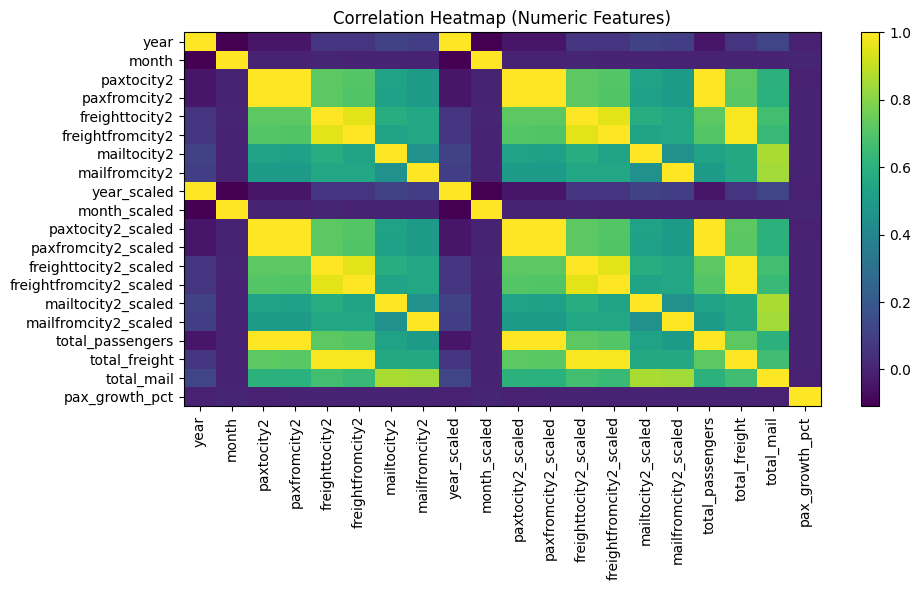

In [9]:
# Correlation on numeric columns only
num_for_corr = df_proc.select_dtypes(include=[np.number]).columns.tolist()
corr = df_proc[num_for_corr].corr()
print('Correlation matrix shape:', corr.shape)

plt.figure(figsize=(10, 6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_for_corr)), num_for_corr, rotation=90)
plt.yticks(range(len(num_for_corr)), num_for_corr)
plt.title('Correlation Heatmap (Numeric Features)')
plt.tight_layout()
plt.show()

## 7) Save Processed Output
Exports a cleaned & augmented CSV for downstream analysis.

In [10]:
OUTPUT_CSV = 'domestic_city_processed.csv'
df_proc.to_csv(OUTPUT_CSV, index=False)
print('Saved:', OUTPUT_CSV)
df_proc.shape

Saved: domestic_city_processed.csv


(56047, 24)

In [11]:
# =====================================================================
# 🧭 INDIA AVIATION — EXPLORATORY DATA ANALYSIS (EDA)
# Dataset: domestic_city_processed.csv
# Libraries: pandas + matplotlib only
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# ---------------------------------------------------------------------
# 1️⃣ Load the dataset
# ---------------------------------------------------------------------
df = pd.read_csv("domestic_city_processed.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())

# Ensure total_passengers column exists
if 'total_passengers' not in df.columns:
    df['total_passengers'] = df['paxtocity2'] + df['paxfromcity2']


Shape: (56047, 24)
Columns: ['year', 'month', 'city1', 'city2', 'paxtocity2', 'paxfromcity2', 'freighttocity2', 'freightfromcity2', 'mailtocity2', 'mailfromcity2', 'date', 'year_scaled', 'month_scaled', 'paxtocity2_scaled', 'paxfromcity2_scaled', 'freighttocity2_scaled', 'freightfromcity2_scaled', 'mailtocity2_scaled', 'mailfromcity2_scaled', 'total_passengers', 'total_freight', 'total_mail', 'pax_growth_pct', 'traffic_type']


,year,month,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,date,year_scaled,month_scaled,paxtocity2_scaled,paxfromcity2_scaled,freighttocity2_scaled,freightfromcity2_scaled,mailtocity2_scaled,mailfromcity2_scaled,total_passengers,total_freight,total_mail,pax_growth_pct,traffic_type
0,2021,12,ADAMPUR,AHMEDABAD,30.0,0.0,0.0,0.00,0.0,0.0,2021-12-01,0.231384,1.543742,-0.457048,-0.457371,-0.211484,-0.196652,-0.285652,-0.249218,30.0,0.00,0.0,NaN,domestic
1,2018,5,ADAMPUR,DELHI,2258.0,2190.0,0.0,0.86,0.0,0.0,2018-05-01,-0.834132,-0.434255,-0.359395,-0.361311,-0.211484,-0.192234,-0.285652,-0.249218,4448.0,0.86,0.0,NaN,domestic
2,2018,6,ADAMPUR,DELHI,1984.0,1981.0,0.0,4.33,0.0,0.0,2018-06-01,-0.834132,-0.151684,-0.371405,-0.370479,-0.211484,-0.174409,-0.285652,-0.249218,3965.0,4.33,0.0,-10.858813,domestic
3,2018,7,ADAMPUR,DELHI,2333.0,2205.0,0.0,1.93,0.0,0.0,2018-07-01,-0.834132,0.130887,-0.356108,-0.360653,-0.211484,-0.186738,-0.285652,-0.249218,4538.0,1.93,0.0,14.451450,domestic
4,2018,8,ADAMPUR,DELHI,2146.0,1981.0,0.0,0.48,0.0,0.0,2018-08-01,-0.834132,0.413458,-0.364304,-0.370479,-0.211484,-0.194186,-0.285652,-0.249218,4127.0,0.48,0.0,-9.056853,domestic


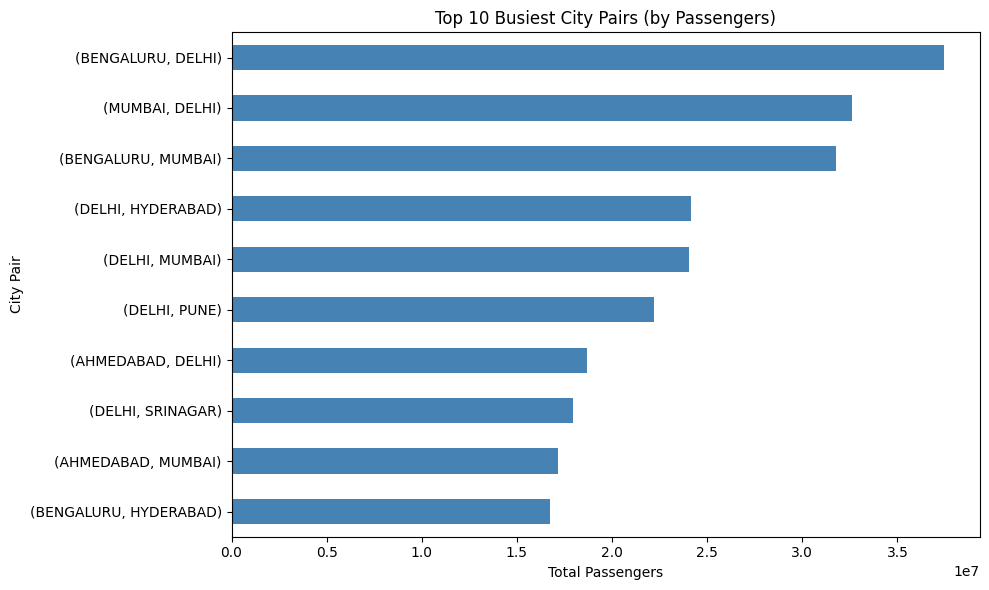

city1      city2    
BENGALURU  DELHI        37468355.0
MUMBAI     DELHI        32629461.0
BENGALURU  MUMBAI       31791771.0
DELHI      HYDERABAD    24142823.0
           MUMBAI       24061209.0
           PUNE         22221613.0
AHMEDABAD  DELHI        18695972.0
DELHI      SRINAGAR     17941599.0
AHMEDABAD  MUMBAI       17163865.0
BENGALURU  HYDERABAD    16725283.0
Name: total_passengers, dtype: float64

In [13]:
# ---------------------------------------------------------------------
# 2️⃣ Top 10 Busiest City Pairs (by total passengers)
# ---------------------------------------------------------------------
top_routes = (
    df.groupby(['city1', 'city2'])['total_passengers']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10,6))
top_routes.plot(kind='barh', color='steelblue')
plt.title('Top 10 Busiest City Pairs (by Passengers)')
plt.xlabel('Total Passengers')
plt.ylabel('City Pair')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

display(top_routes)

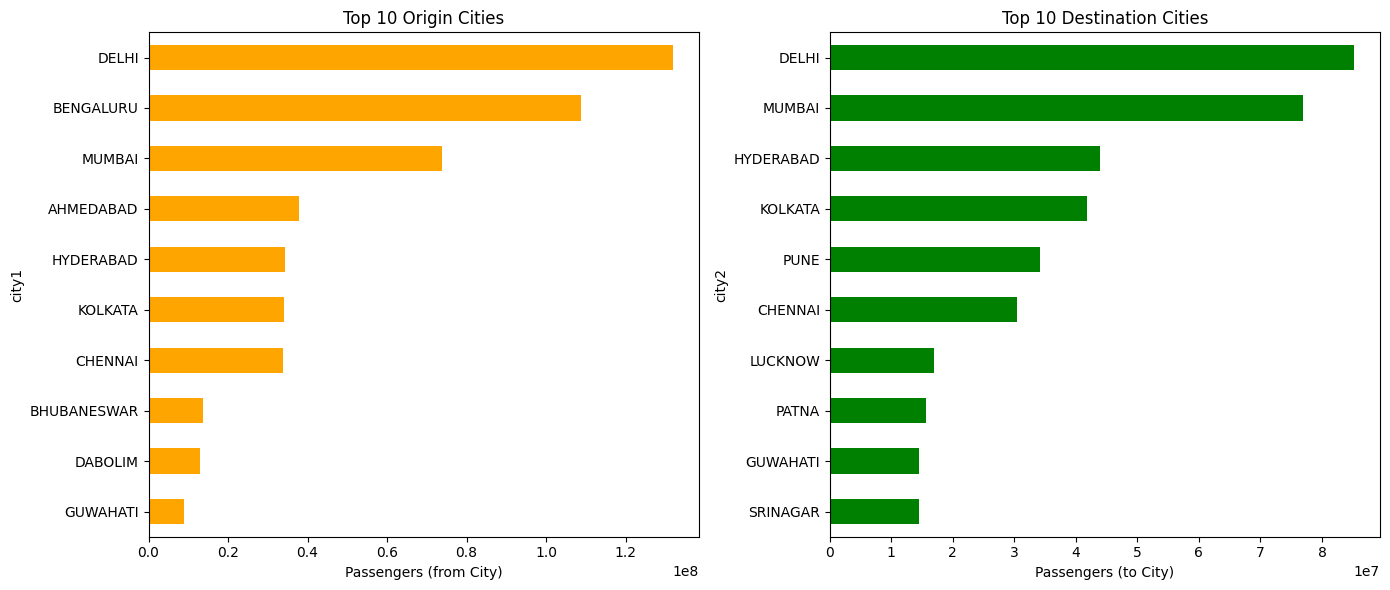

In [14]:
# ---------------------------------------------------------------------
# 3️⃣ Top 10 Origin & Destination Cities
# ---------------------------------------------------------------------

# Total outgoing and incoming passengers
top_origin = (
    df.groupby('city1')['paxfromcity2']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)
top_destination = (
    df.groupby('city2')['paxtocity2']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

fig, axes = plt.subplots(1, 2, figsize=(14,6))
top_origin.plot(kind='barh', ax=axes[0], color='orange')
axes[0].invert_yaxis()
axes[0].set_title('Top 10 Origin Cities')
axes[0].set_xlabel('Passengers (from City)')

top_destination.plot(kind='barh', ax=axes[1], color='green')
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Destination Cities')
axes[1].set_xlabel('Passengers (to City)')

plt.tight_layout()
plt.show()

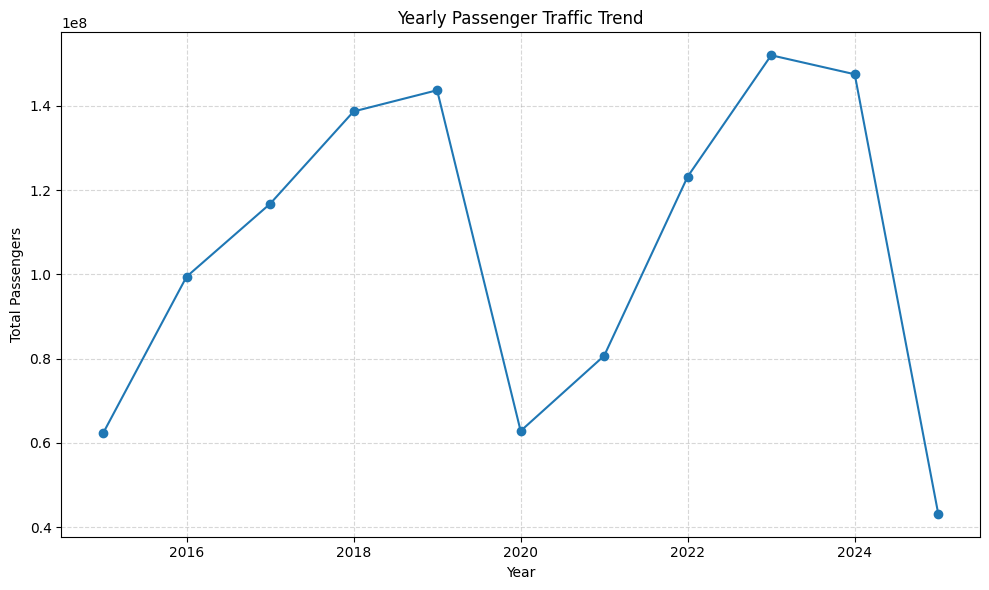

year
2015     62297851.0
2016     99473433.0
2017    116773731.0
2018    138698284.0
2019    143736256.0
2020     62852011.0
2021     80707707.0
2022    123242014.0
2023    152040530.0
2024    147529952.0
2025     43193966.0
Name: total_passengers, dtype: float64

In [15]:
# ---------------------------------------------------------------------
# 4️⃣ Yearly Trends (sum of total passengers per year)
# ---------------------------------------------------------------------
yearly_trend = (
    df.groupby('year')['total_passengers']
      .sum()
      .sort_index()
)

plt.figure(figsize=(10,6))
plt.plot(yearly_trend.index, yearly_trend.values, marker='o')
plt.title('Yearly Passenger Traffic Trend')
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

display(yearly_trend)


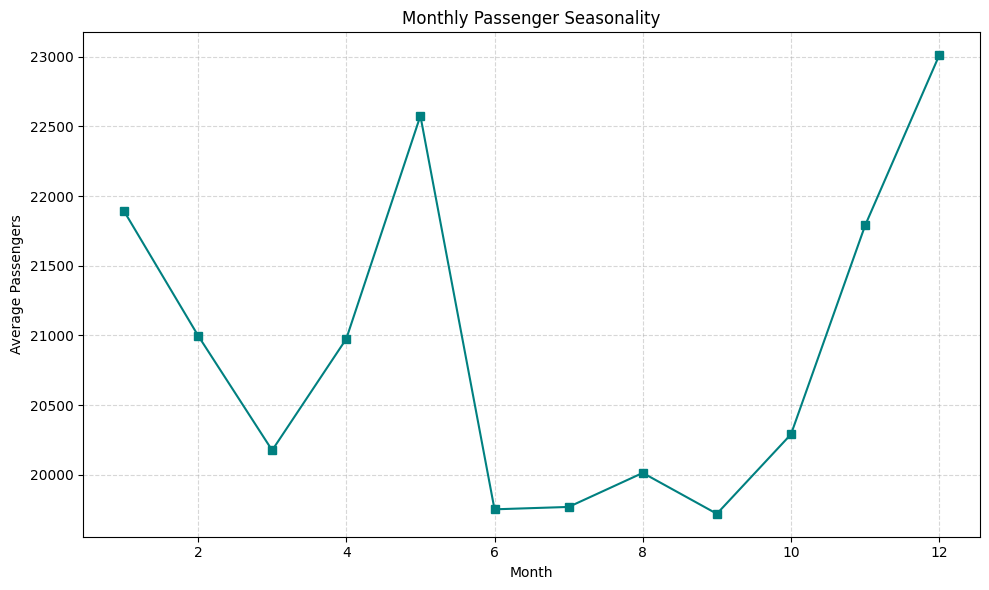

month
1     21893.435477
2     20999.292678
3     20175.672140
4     20975.225760
5     22575.912768
6     19752.041276
7     19769.157814
8     20013.343750
9     19719.945906
10    20290.413580
11    21789.048203
12    23010.643982
Name: total_passengers, dtype: float64

In [16]:
# ---------------------------------------------------------------------
# 5️⃣ Monthly Seasonality (average passengers across years)
# ---------------------------------------------------------------------
monthly_season = (
    df.groupby('month')['total_passengers']
      .mean()
      .sort_index()
)

plt.figure(figsize=(10,6))
plt.plot(monthly_season.index, monthly_season.values, marker='s', color='teal')
plt.title('Monthly Passenger Seasonality')
plt.xlabel('Month')
plt.ylabel('Average Passengers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

display(monthly_season)

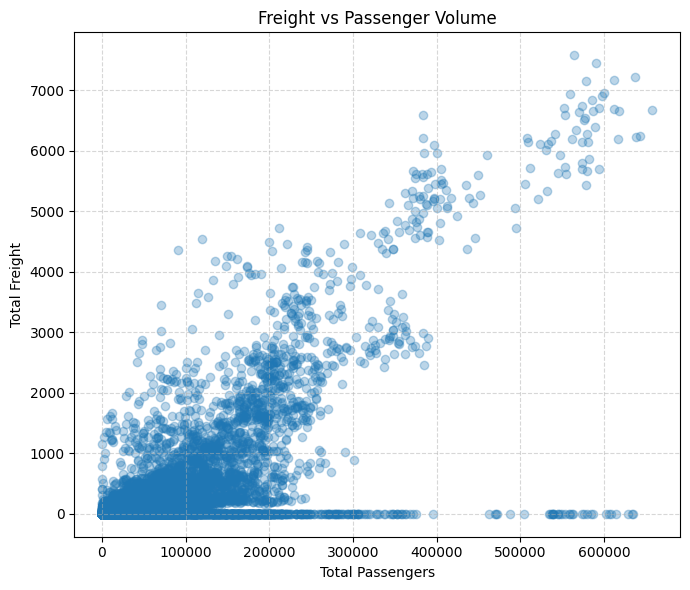

Correlation between passengers and freight: 0.720


In [17]:
# ---------------------------------------------------------------------
# 6️⃣ Freight vs Passengers Relationship
# ---------------------------------------------------------------------
plt.figure(figsize=(7,6))
plt.scatter(df['total_passengers'], df['total_freight'], alpha=0.3)
plt.title('Freight vs Passenger Volume')
plt.xlabel('Total Passengers')
plt.ylabel('Total Freight')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

corr_value = df[['total_passengers','total_freight']].corr().iloc[0,1]
print(f"Correlation between passengers and freight: {corr_value:.3f}")


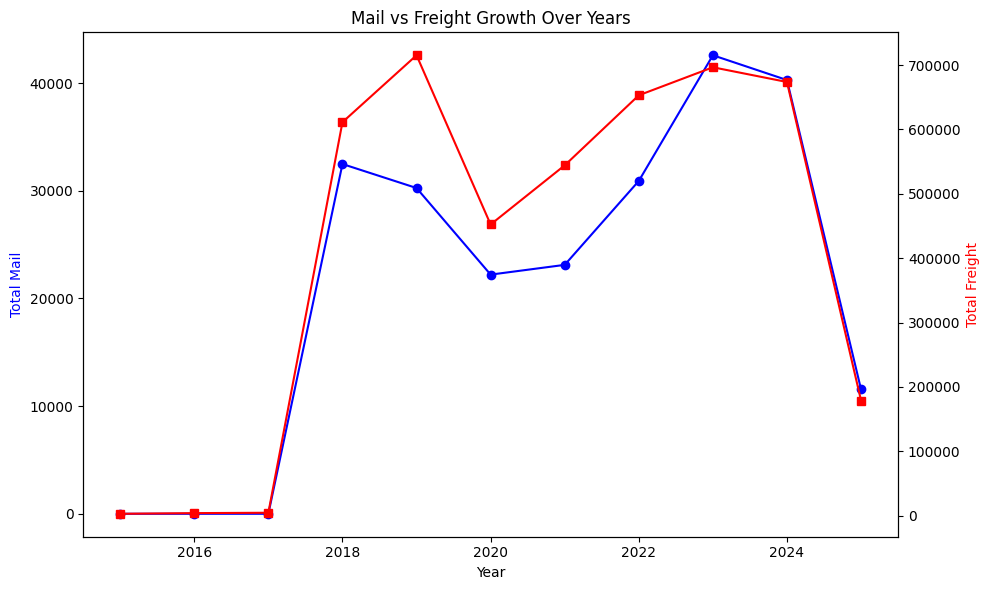

In [18]:
# ---------------------------------------------------------------------
# 7️⃣ Mail Traffic vs Freight Growth (Dual Axis)
# ---------------------------------------------------------------------
yearly_mail = df.groupby('year')['total_mail'].sum()
yearly_freight = df.groupby('year')['total_freight'].sum()

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1.plot(yearly_mail.index, yearly_mail.values, color='blue', marker='o', label='Mail')
ax2.plot(yearly_freight.index, yearly_freight.values, color='red', marker='s', label='Freight')

ax1.set_xlabel('Year')
ax1.set_ylabel('Total Mail', color='blue')
ax2.set_ylabel('Total Freight', color='red')
plt.title('Mail vs Freight Growth Over Years')
plt.tight_layout()
plt.show()

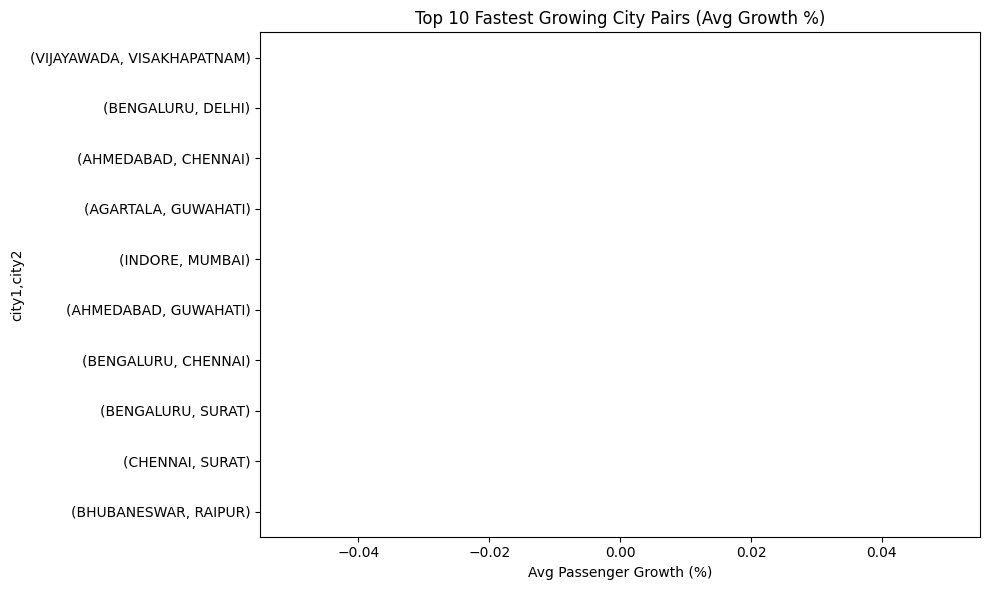

city1        city2        
VIJAYAWADA   VISAKHAPATNAM    inf
BENGALURU    DELHI            inf
AHMEDABAD    CHENNAI          inf
AGARTALA     GUWAHATI         inf
INDORE       MUMBAI           inf
AHMEDABAD    GUWAHATI         inf
BENGALURU    CHENNAI          inf
             SURAT            inf
CHENNAI      SURAT            inf
BHUBANESWAR  RAIPUR           inf
Name: pax_growth_pct, dtype: float64

In [ ]:
# ---------------------------------------------------------------------
# 8️⃣ City Pair Growth % (average pax_growth_pct)
# ---------------------------------------------------------------------
if 'pax_growth_pct' in df.columns:
    growth_avg = (
        df.groupby(['city1','city2'])['pax_growth_pct']
          .mean()
          .sort_values(ascending=False)
          .dropna()
          .head(10)
    )
    plt.figure(figsize=(10,6))
    growth_avg.plot(kind='barh', color='purple')
    plt.title('Top 10 Fastest Growing City Pairs (Avg Growth %)')
    plt.xlabel('Avg Passenger Growth (%)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    display(growth_avg)
else:
    print("Column 'pax_growth_pct' not found in dataset.")
    
    

Aggregated shape: (1679, 11)


,city1,city2,paxtocity2,paxfromcity2,freighttocity2,freightfromcity2,mailtocity2,mailfromcity2,total_passengers,total_freight,total_mail
0,ADAMPUR,AHMEDABAD,30.0,0.0,0.00,0.00,0.0,0.0,30.0,0.00,0.0
1,ADAMPUR,DELHI,58411.0,57543.0,7.16,30.46,0.0,0.0,115954.0,37.62,0.0
2,ADAMPUR,GUWAHATI,0.0,5.0,0.00,0.00,0.0,0.0,5.0,0.00,0.0
3,ADAMPUR,HINDON AIRPORT,16622.0,15986.0,0.00,0.00,0.0,0.0,32608.0,0.00,0.0
4,ADAMPUR,JAIPUR,66.0,66.0,0.11,0.00,0.0,0.0,132.0,0.11,0.0


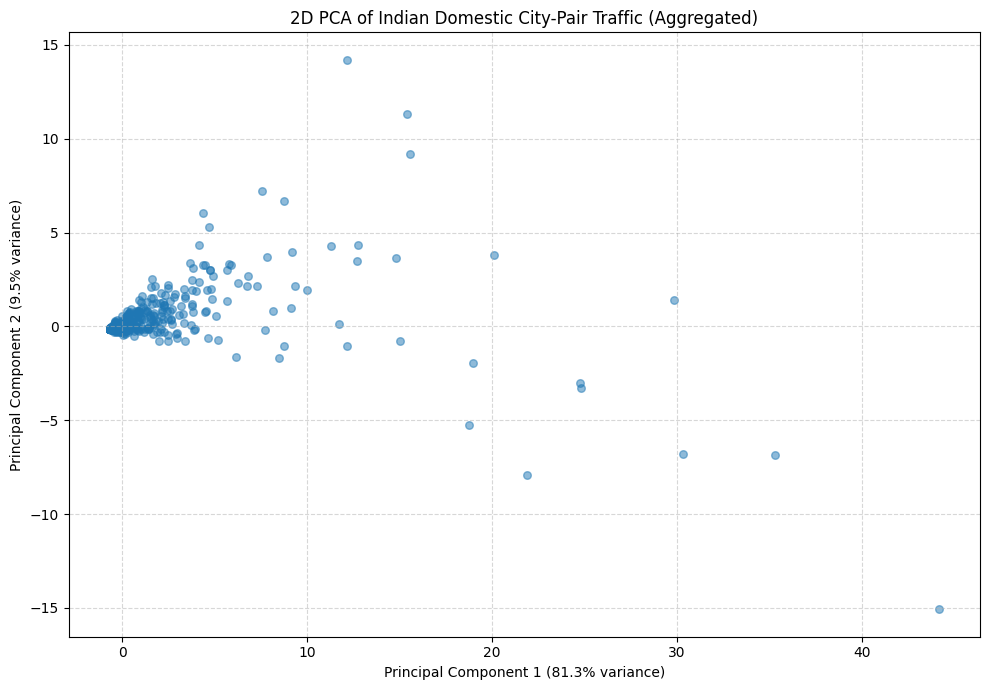

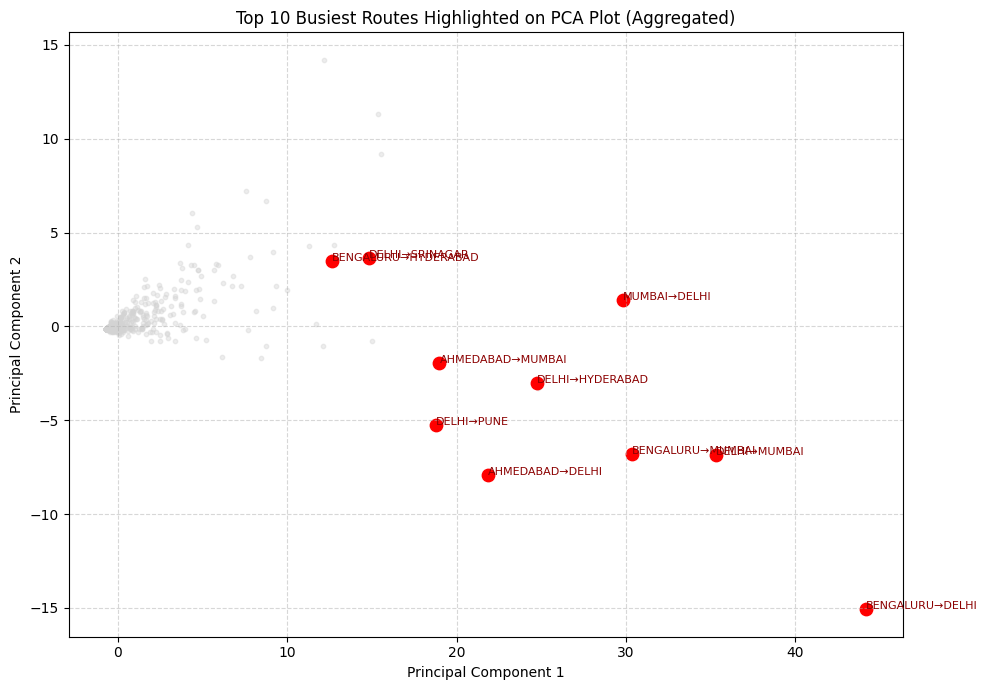

Explained Variance by PC1: 81.26%
Explained Variance by PC2: 9.51%


In [29]:
# =====================================================================
# 🧭 PCA with Aggregated City-Pair Data (One row per route)
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv("domestic_city_processed.csv")

# --- Step 1: Aggregate by route (City1 → City2)
agg_df = df.groupby(['city1', 'city2']).agg({
    'paxtocity2': 'sum',
    'paxfromcity2': 'sum',
    'freighttocity2': 'sum',
    'freightfromcity2': 'sum',
    'mailtocity2': 'sum',
    'mailfromcity2': 'sum',
    'total_passengers': 'sum',
    'total_freight': 'sum',
    'total_mail': 'sum'
}).reset_index()

print("Aggregated shape:", agg_df.shape)
display(agg_df.head())

# --- Step 2: Select numeric features for PCA
features = [
    'paxtocity2', 'paxfromcity2',
    'freighttocity2', 'freightfromcity2',
    'mailtocity2', 'mailfromcity2',
    'total_passengers', 'total_freight', 'total_mail'
]
X = agg_df[features].fillna(0)

# --- Step 3: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 4: PCA (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

agg_df['PC1'] = X_pca[:, 0]
agg_df['PC2'] = X_pca[:, 1]

# --- Step 5: Plot the results
plt.figure(figsize=(10,7))
plt.scatter(agg_df['PC1'], agg_df['PC2'], alpha=0.5, s=30)
plt.title("2D PCA of Indian Domestic City-Pair Traffic (Aggregated)")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Step 6: Highlight Top 10 Routes
top_routes = agg_df.sort_values('total_passengers', ascending=False).head(10)

plt.figure(figsize=(10,7))
plt.scatter(agg_df['PC1'], agg_df['PC2'], color='lightgray', alpha=0.4, s=10)
plt.scatter(top_routes['PC1'], top_routes['PC2'], color='red', s=80)

for _, row in top_routes.iterrows():
    plt.text(row['PC1'], row['PC2'], f"{row['city1']}→{row['city2']}", fontsize=8, color='darkred')

plt.title("Top 10 Busiest Routes Highlighted on PCA Plot (Aggregated)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Explained Variance by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Explained Variance by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")


Data shape: (1679, 5)


,city1,city2,total_passengers,total_freight,total_mail
0,ADAMPUR,AHMEDABAD,30.0,0.00,0.0
1,ADAMPUR,DELHI,115954.0,37.62,0.0
2,ADAMPUR,GUWAHATI,5.0,0.00,0.0
3,ADAMPUR,HINDON AIRPORT,32608.0,0.00,0.0
4,ADAMPUR,JAIPUR,132.0,0.11,0.0


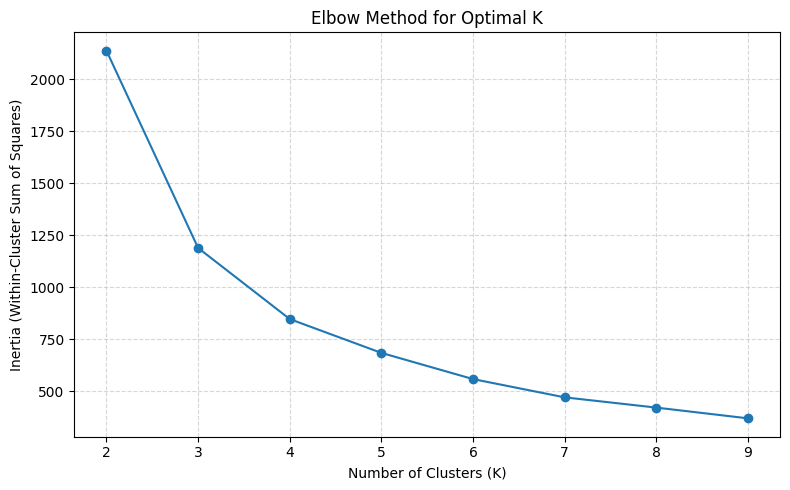

✅ Assigned 4 clusters


,city1,city2,total_passengers,total_freight,total_mail,cluster
0,ADAMPUR,AHMEDABAD,30.0,0.00,0.0,0
1,ADAMPUR,DELHI,115954.0,37.62,0.0,0
2,ADAMPUR,GUWAHATI,5.0,0.00,0.0,0
3,ADAMPUR,HINDON AIRPORT,32608.0,0.00,0.0,0
4,ADAMPUR,JAIPUR,132.0,0.11,0.0,0


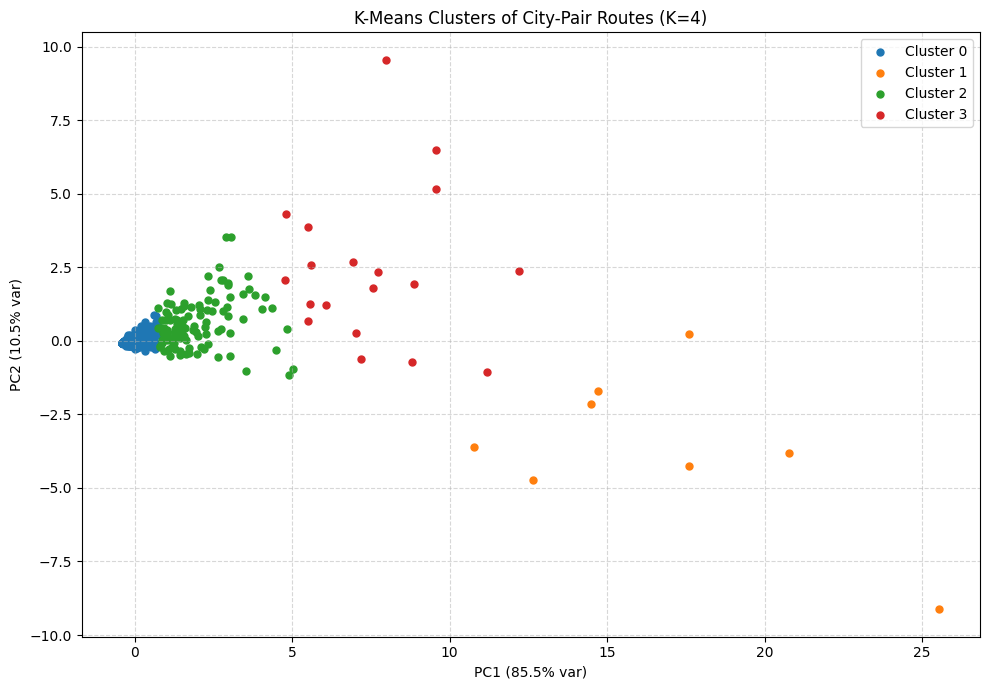

📊 Cluster Summary (Average Traffic per Group):


,total_passengers,total_freight,total_mail
cluster,,,
0,180577.78,258.13,21.43
1,25602197.25,223250.89,3880.54
2,4335698.17,11928.65,923.46
3,10852384.16,54140.88,3517.86



🔹 Cluster 0 → 1541 routes
           city1     city2  total_passengers  total_freight  total_mail
295    BENGALURU       GOA         3870289.0        2444.45       28.91
1269     KOLKATA  AGARTALA         3417252.0        4923.93      191.37
556   COIMBATORE   CHENNAI         3255308.0        2035.61       44.85

🔹 Cluster 1 → 8 routes
          city1   city2  total_passengers  total_freight  total_mail
290   BENGALURU   DELHI        37468355.0      389732.97     4517.14
1452     MUMBAI   DELHI        32629461.0      154660.02     5185.48
326   BENGALURU  MUMBAI        31791771.0      215815.70     3465.60

🔹 Cluster 2 → 111 routes
          city1      city2  total_passengers  total_freight  total_mail
335   BENGALURU       PUNE        13654235.0       41018.32      832.05
1278    KOLKATA      DELHI        11459307.0       51466.80      879.02
1465     MUMBAI  HYDERABAD        10258719.0       39580.97     1150.44

🔹 Cluster 3 → 19 routes
         city1      city2  total_passengers  t

In [31]:
# =====================================================================
# ✈️ INDIA AVIATION — CLUSTERING MODULE (K-MEANS)
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ---------------------------------------------------------------------
# 1️⃣ Load dataset (aggregated city-pair data from PCA step)
# ---------------------------------------------------------------------
df = pd.read_csv("domestic_city_processed.csv")

# Aggregate by route so each route appears once
agg_df = df.groupby(['city1', 'city2']).agg({
    'total_passengers': 'sum',
    'total_freight': 'sum',
    'total_mail': 'sum'
}).reset_index()

print("Data shape:", agg_df.shape)
display(agg_df.head())

# ---------------------------------------------------------------------
# 2️⃣ Standardize features for clustering
# ---------------------------------------------------------------------
features = ['total_passengers', 'total_freight', 'total_mail']
X = agg_df[features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------------------
# 3️⃣ Determine optimal number of clusters (Elbow Method)
# ---------------------------------------------------------------------
inertias = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4️⃣ Choose K (you can change based on the elbow plot)
# ---------------------------------------------------------------------
optimal_k = 4  # start with 4 clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
agg_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ Assigned {optimal_k} clusters")
display(agg_df.head())

# ---------------------------------------------------------------------
# 5️⃣ Visualize clusters in 2D PCA space
# ---------------------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
agg_df['PC1'] = X_pca[:, 0]
agg_df['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10,7))
for c in range(optimal_k):
    subset = agg_df[agg_df['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=25, label=f'Cluster {c}')
plt.title(f'K-Means Clusters of City-Pair Routes (K={optimal_k})')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 6️⃣ Summarize cluster characteristics
# ---------------------------------------------------------------------
cluster_summary = agg_df.groupby('cluster')[features].mean().round(2)
print("📊 Cluster Summary (Average Traffic per Group):")
display(cluster_summary)

# ---------------------------------------------------------------------
# 7️⃣ Identify representative routes per cluster
# ---------------------------------------------------------------------
for c in range(optimal_k):
    subset = agg_df[agg_df['cluster'] == c]
    top_routes = subset.sort_values('total_passengers', ascending=False).head(3)
    print(f"\n🔹 Cluster {c} → {len(subset)} routes")
    print(top_routes[['city1','city2','total_passengers','total_freight','total_mail']])


Aggregated data shape: (1679, 3)


,city1,city2,total_passengers
0,ADAMPUR,AHMEDABAD,30.0
1,ADAMPUR,DELHI,115954.0
2,ADAMPUR,GUWAHATI,5.0
3,ADAMPUR,HINDON AIRPORT,32608.0
4,ADAMPUR,JAIPUR,132.0


One-hot encoded shape: (124, 144)


,AGARTALA,AHMEDABAD,AIZAWL,AJMER,ALIGARH AIRPORT,ALLAHABAD,AMBIKAPUR AIRPORT,AMRITSAR,AURANGABAD,AYODHYA INTERNATIONAL AIRPORT,AZAMGARH AIRPORT,BAGDOGRA,BELGAUM,BENGALURU,BHAVNAGAR,BHOPAL,BHUBANESWAR,BHUJ,BIDAR,"BIDAR AIRPORT, KARNATAKA",BILASPUR,CHANDIGARH,CHENNAI,CHITRAKOOT AIRPORT,COCHIN,COIMBATORE,CUDDAPAH,DABOLIM,DARBHANGA,DEHRA DUN,DEHRADUN,DELHI,DEOGHAR,DEOGHAR AIRPORT,DHARAMSALA,DIBRUGARH,DIMAPUR,DIU,DURGAPUR,GANGTOK,GAYA,GHAZIABAD,GOA,GONDIA AIRPORT,GORAKHPUR,GUWAHATI,GWALIOR,HINDON AIRPORT,HISSAR,"HOLLONGI AIRPORT, ITANAGAR",HUBLI,HYDERABAD,IMPHAL,INDORE,ITANAGAR,JABALPUR,JAGDALPUR,JAIPUR,JAISALMER,JALGAON,JAMMU,JAMNAGAR,JAMSHEDPUR,JEYPORE,JHARSUGUDA,JODHPUR,JORHAT,KADAPA,KALABURAGI,"KALABURAGI, KARNATAKA",KANDLA,KANNUR,KANPUR,KESHOD,KHAJURAHO,KISHANGARH,KOCHI,KOLHAPUR,KOLKATA,KOZHIKODE,KULLU,KURNOOL,KUSHINAGAR,KUSHINAGAR INTERNATIONAL AIRPORT,LEH,LILABARI,LUCKNOW,LUDHIANA,MADURAI,MALVAN,MANGALORE,MORADABAD AIRPORT,MUMBAI,MUNDRA,MYSORE,NAGPUR,NANDED,NASIK,PAKYONG,PANTNAGAR,PASIGHAT,PATHANKOT,PATNA,PITHORAGARH,PONDICHERRY,PORBANDAR,PORT BLAIR,PRAYAGRAJ,PUDUCHERRY,PUNE,RAIPUR,RAJAHMUNDRY,RAJKOT,RAJKOT INTERNATIONAL AIRPORT,RANCHI,REWA,ROURKELA,RUPSI,SALEM,SHILLONG,SHIRDI,SHIVAMOGGA AIRPORT,SHRAVASTI AIRPORT,SILCHAR,SIMLA,SINDHUDURG AIRPORT,SRINAGAR,SURAT,TEZPUR,TEZU,TIRUCHIRAPALLY,TIRUPATI,TRIVANDRUM,TUTICORIN,UDAIPUR,UTKELA,UTTARLAI,VADODARA,VARANASI,VIDYANAGAR,VIJAYAWADA,VISAKHAPATNAM,ZERO AIRPORT,ZIRO
city1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ADAMPUR,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AGARTALA,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
AGATTI ISLAND,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AGRA,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
AHMEDABAD,0,0,0,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,0,0,0,1,1,0,0,1,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Top Frequent City Combinations:


,support,itemsets
24,0.540323,(MUMBAI)
29,0.427419,(PUNE)
19,0.411290,(KOLKATA)
314,0.362903,"(KOLKATA, MUMBAI)"
377,0.362903,"(PUNE, MUMBAI)"
42,0.362903,(VARANASI)
21,0.362903,(LUCKNOW)
15,0.346774,(JAIPUR)
11,0.346774,(HYDERABAD)
44,0.338710,(VISAKHAPATNAM)


Top Association Rules Between Cities:


,antecedents,consequents,support,confidence,lift
1484193,"(JAIPUR, MUMBAI, TRIVANDRUM, VADODARA)","(SURAT, PUNE)",0.104839,1.0,4.769231
1484196,"(SURAT, MUMBAI, TRIVANDRUM, VADODARA)","(JAIPUR, PUNE)",0.104839,1.0,3.757576
1484200,"(JAIPUR, SURAT, MUMBAI, VADODARA)","(PUNE, TRIVANDRUM)",0.104839,1.0,4.960000
1484133,"(SURAT, MUMBAI, VARANASI, TRIVANDRUM)","(JAIPUR, PUNE)",0.104839,1.0,3.757576
1484246,"(VISAKHAPATNAM, JAIPUR, VARANASI, MUMBAI, RANCHI)",(PUNE),0.104839,1.0,2.339623
1484121,"(TRIVANDRUM, JAIPUR, SURAT, VARANASI, MUMBAI)",(PUNE),0.104839,1.0,2.339623
1484124,"(TRIVANDRUM, SURAT, VARANASI, PUNE, MUMBAI)",(JAIPUR),0.104839,1.0,2.883721
1484308,"(TRIVANDRUM, JAIPUR, SURAT, MUMBAI, RANCHI)",(PUNE),0.104839,1.0,2.339623
313933,"(PUNE, VARANASI, VADODARA, RANCHI)","(RAIPUR, PATNA)",0.120968,1.0,5.166667
313932,"(PUNE, VARANASI, VADODARA, PATNA)","(RAIPUR, RANCHI)",0.120968,1.0,5.166667


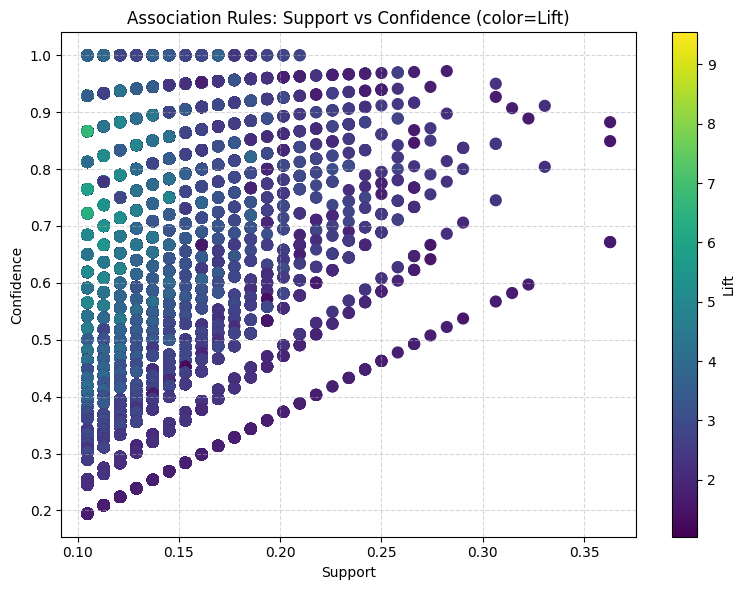

In [34]:
# =====================================================================
# ✈️ INDIA AVIATION — ASSOCIATION RULES MODULE (Apriori)
# =====================================================================

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1️⃣ Load dataset (aggregated by route)
# ---------------------------------------------------------------------
df = pd.read_csv("domestic_city_processed.csv")

# Aggregate by route (City1 -> City2)
agg_df = df.groupby(['city1', 'city2']).agg({
    'total_passengers': 'sum'
}).reset_index()

print("Aggregated data shape:", agg_df.shape)
display(agg_df.head())

# ---------------------------------------------------------------------
# 2️⃣ Prepare data for association rule mining
# ---------------------------------------------------------------------
# We’ll treat each origin city (city1) as a “basket”
# and destinations (city2) as “items” in that basket.

# Create a list of destinations per origin
basket = agg_df.groupby('city1')['city2'].apply(list)

# Convert to one-hot encoded dataframe
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
basket_encoded = pd.DataFrame(mlb.fit_transform(basket),
                              columns=mlb.classes_,
                              index=basket.index)

print("One-hot encoded shape:", basket_encoded.shape)
display(basket_encoded.head())

# ---------------------------------------------------------------------
# 3️⃣ Run Apriori algorithm to find frequent itemsets
# ---------------------------------------------------------------------
frequent_itemsets = apriori(
    basket_encoded,
    min_support=0.1,  # 10% support threshold; adjust as needed
    use_colnames=True
)
frequent_itemsets.sort_values('support', ascending=False, inplace=True)

print("Top Frequent City Combinations:")
display(frequent_itemsets.head(10))

# ---------------------------------------------------------------------
# 4️⃣ Generate Association Rules
# ---------------------------------------------------------------------
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by='confidence', ascending=False)

print("Top Association Rules Between Cities:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# ---------------------------------------------------------------------
# 5️⃣ Visualize relationships
# ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', s=60)
plt.colorbar(label='Lift')
plt.title('Association Rules: Support vs Confidence (color=Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Basket shape: (108, 127)
Frequent itemsets: 204


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
163,NASIK,PUNE,0.101852,1.000000,2.918919
73,DABOLIM,HYDERABAD,0.138889,1.000000,2.769231
56,NAGPUR,PUNE,0.157407,0.944444,2.756757
84,GOA,JAIPUR,0.138889,0.937500,3.491379
88,GOA,HYDERABAD,0.138889,0.937500,2.596154
90,DABOLIM,CHENNAI,0.129630,0.933333,2.964706
92,DABOLIM,MUMBAI,0.129630,0.933333,1.625806
11,LUCKNOW,MUMBAI,0.222222,0.923077,1.607940
164,UDAIPUR,PUNE,0.101852,0.916667,2.675676
30,GUWAHATI,HYDERABAD,0.185185,0.909091,2.517483


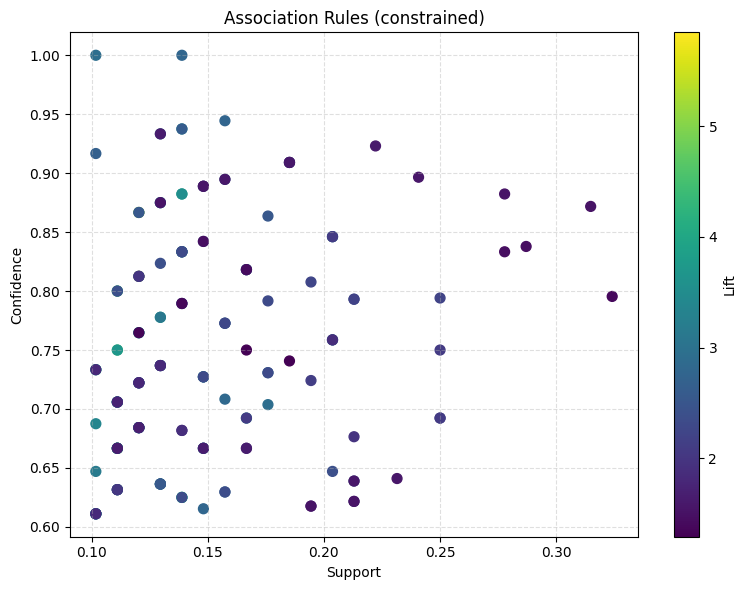

In [37]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# 1) Build a compact basket (origin → destinations as items)
df = pd.read_csv("domestic_city_processed.csv")

# Aggregate once per (city1, city2)
agg = df.groupby(['city1','city2'])['total_passengers'].sum().reset_index()

# (a) Drop ultra-rare routes to shrink columns (tune this threshold)
ROUTE_MIN_PAX = 5000   # e.g., keep routes with ≥5k total pax
agg = agg[agg['total_passengers'] >= ROUTE_MIN_PAX]

# (b) Pivot to one-hot (boolean) – uint8 saves memory
basket = (agg.pivot_table(index='city1', columns='city2',
                          values='total_passengers', aggfunc='sum', fill_value=0) > 0).astype('uint8')

print("Basket shape:", basket.shape)

# 2) Apriori with tight bounds
MIN_SUPPORT = 0.10  # try 0.10–0.20 first; lower later if needed
freq = apriori(basket, min_support=MIN_SUPPORT, use_colnames=True, max_len=2)
freq = freq.sort_values('support', ascending=False)
print("Frequent itemsets:", freq.shape[0])

# 3) Rules with min confidence and lift
rules = association_rules(freq, metric="confidence", min_threshold=0.6)
rules = rules[rules['lift'] > 1.0]

# Flatten frozensets without making a big copy
rules['antecedents'] = rules['antecedents'].apply(lambda s: next(iter(s)) if len(s) else None)
rules['consequents'] = rules['consequents'].apply(lambda s: next(iter(s)) if len(s) else None)

# Keep only the strongest N edges to avoid plotting overload
rules = rules.sort_values(['confidence','lift','support'], ascending=False).head(200)
rules_small = rules[['antecedents','consequents','support','confidence','lift']]
display(rules_small.head(20))

# 4) Quick scatter (support vs confidence; color by lift)
plt.figure(figsize=(8,6))
sc = plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], s=50)
plt.colorbar(sc, label='Lift')
plt.xlabel('Support'); plt.ylabel('Confidence')
plt.title('Association Rules (constrained)')
plt.grid(True, linestyle='--', alpha=0.4); plt.tight_layout(); plt.show()


,dest_A,dest_B,support_pair,support_A,support_B,confidence,lift
1747,BHUJ,PRAYAGRAJ,0.009259,0.009259,0.009259,1.0,108.0
1793,BIDAR,"BIDAR AIRPORT, KARNATAKA",0.009259,0.009259,0.009259,1.0,108.0
1838,BIDAR,KALABURAGI,0.009259,0.009259,0.009259,1.0,108.0
1919,"BIDAR AIRPORT, KARNATAKA",BIDAR,0.009259,0.009259,0.009259,1.0,108.0
1965,"BIDAR AIRPORT, KARNATAKA",KALABURAGI,0.009259,0.009259,0.009259,1.0,108.0
3629,DEOGHAR AIRPORT,KUSHINAGAR,0.009259,0.009259,0.009259,1.0,108.0
3630,DEOGHAR AIRPORT,KUSHINAGAR INTERNATIONAL AIRPORT,0.009259,0.009259,0.009259,1.0,108.0
3634,DEOGHAR AIRPORT,LUDHIANA,0.009259,0.009259,0.009259,1.0,108.0
3646,DEOGHAR AIRPORT,PATHANKOT,0.009259,0.009259,0.009259,1.0,108.0
5296,"HOLLONGI AIRPORT, ITANAGAR",PASIGHAT,0.009259,0.009259,0.009259,1.0,108.0


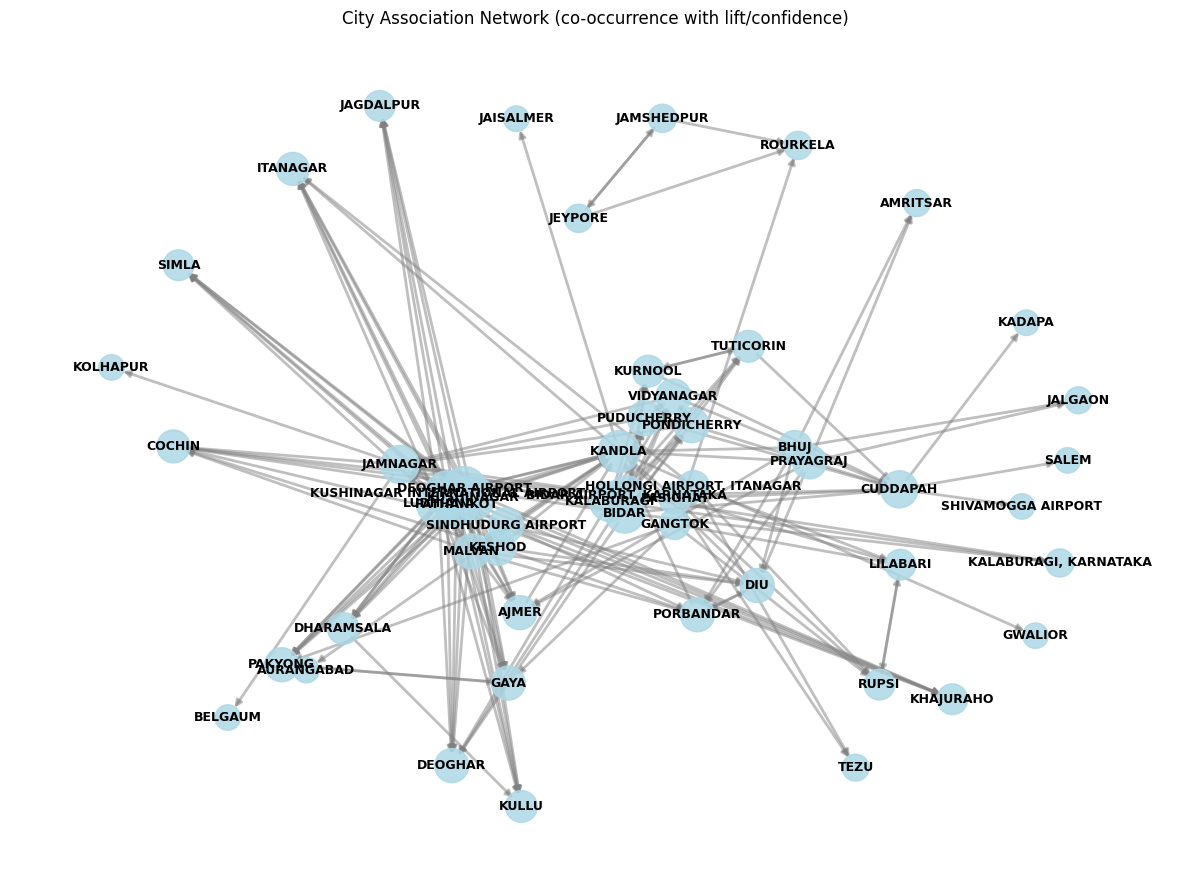

In [40]:
# C is your co-occurrence matrix: C = B.T.dot(B)
# Give distinct axis names to avoid reset_index() name collisions
C = C.rename_axis(index='dest_A', columns='dest_B')

n_origins = B.shape[0]
supp = C / n_origins                      # pair support
supp_item = (B.sum(axis=0) / n_origins)   # single-destination support

# Build tidy pair table
pairs = (
    supp.stack()                          # -> Series with MultiIndex (dest_A, dest_B)
         .rename('support_pair')          # name the value column
         .reset_index()                   # columns: dest_A, dest_B, support_pair
)

# Drop self-pairs and zeros
pairs = pairs[(pairs['dest_A'] != pairs['dest_B']) & (pairs['support_pair'] > 0)]

# Add supports for A and B
pairs = pairs.merge(supp_item.rename('support_A'), left_on='dest_A', right_index=True)
pairs = pairs.merge(supp_item.rename('support_B'), left_on='dest_B', right_index=True)

# Confidence and lift
pairs['confidence'] = pairs['support_pair'] / pairs['support_A']
pairs['lift'] = pairs['support_pair'] / (pairs['support_A'] * pairs['support_B'])

# Filter to strong relations and cap size to avoid memory strain
pairs = pairs[(pairs['confidence'] >= 0.6) & (pairs['lift'] > 1.0)]
pairs = pairs.sort_values(['confidence','lift','support_pair'], ascending=False).head(200)

display(pairs.head(20))

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for _, r in pairs.iterrows():
    G.add_edge(r['dest_A'], r['dest_B'], weight=float(r['confidence']), lift=float(r['lift']))

pos = nx.spring_layout(G, k=0.5, seed=42)
node_size = [300 + 2000*nx.degree_centrality(G)[n] for n in G.nodes()]
edge_w = [G[u][v]['weight']*2 for u,v in G.edges()]

plt.figure(figsize=(12,9))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', alpha=0.85)
nx.draw_networkx_edges(G, pos, width=edge_w, alpha=0.5, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
plt.title("City Association Network (co-occurrence with lift/confidence)")
plt.axis('off'); plt.tight_layout(); plt.show()
